In [1]:
import sys

In [2]:
import numpy as np
import pandas as pd
import tweepy
import matplotlib.pyplot as plt
import pymongo
import ipywidgets as wgt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import re
from datetime import datetime

%matplotlib inline

In [3]:

api_key = "1dSWQ7sR4VzVcx0GmLBZwLN7t" # <---- Add your API Key
api_secret = "ngma3SLArKBPgtTAu5RP88SwBpKPVZhUSwhAsFHP4Dw0c0zu56" # <---- Add your API Secret
access_token = "1089121501897342977-4t0Rv3crUu6kDTOInQKJfeQeX0WCtq" # <---- Add your access token
access_token_secret = "hpr7WwHndEwFhd68XjCsKpMLBkIGraAv5TRmUNU5QKGL3" # <---- Add your access token secret

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)
col = pymongo.MongoClient()["americanelection2020"]["Harris2020"]
col.count()

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  # This is added back by InteractiveShellApp.init_path()


0

In [4]:
class MyStreamListener(tweepy.StreamListener):
    
    counter = 0
    
    def __init__(self, max_tweets=5000, *args, **kwargs):
        self.max_tweets = max_tweets
        self.counter = 0
        super().__init__(*args, **kwargs)
    
    def on_connect(self):
        self.counter = 0
        self.start_time = datetime.now()
    
    def on_status(self, status):
        # Increment counter
        self.counter += 1
        
        # Store tweet to MongoDB
        col.insert_one(status._json)
        
        
        if self.counter % 1 == 0:
            value = int(100.00 * self.counter / self.max_tweets)
            mining_time = datetime.now() - self.start_time
            progress_bar.value = value
            html_value = """<span class="label label-primary">Tweets/Sec: %.1f</span>""" % (self.counter / max([1,mining_time.seconds]))
            html_value += """ <span class="label label-success">Progress: %.1f%%</span>""" % (self.counter / self.max_tweets * 100.0)
            html_value += """ <span class="label label-info">ETA: %.1f Sec</span>""" % ((self.max_tweets - self.counter) / (self.counter / max([1,mining_time.seconds])))
            wgt_status.value = html_value
            #print("%s/%s" % (self.counter, self.max_tweets))
            if self.counter >= self.max_tweets:
                myStream.disconnect()
                print("Finished")
                print("Total Mining Time: %s" % (mining_time))
                print("Tweets/Sec: %.1f" % (self.max_tweets / mining_time.seconds))
                progress_bar.value = 0
                
    
myStreamListener = MyStreamListener(max_tweets=5000)
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
keywords = ["2020",
            "American Election","Harris", "Build Back Better"
           ]

# Visualize a progress bar to track progress
progress_bar = wgt.IntProgress(value=0)
display(progress_bar)
wgt_status = wgt.HTML(value="""<span class="label label-primary">Tweets/Sec: 0.0</span>""")
display(wgt_status)

# Start a filter with an error counter of 20
for error_counter in range(20):
    try:
        myStream.filter(track=keywords)
        print("Tweets collected: %s" % myStream.listener.counter)
        print("Total tweets in collection: %s" % col.count())
        break
    except:
        print("ERROR# %s" % (error_counter + 1))

IntProgress(value=0)

HTML(value='<span class="label label-primary">Tweets/Sec: 0.0</span>')

Finished
Total Mining Time: 0:01:39.026911
Tweets/Sec: 50.5
Tweets collected: 5000
Total tweets in collection: 5000


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere


In [5]:
col.find_one()

{'_id': ObjectId('5f8f460a50177781efc6fa4b'),
 'created_at': 'Tue Oct 20 20:18:13 +0000 2020',
 'id': 1318647733335490562,
 'id_str': '1318647733335490562',
 'text': 'RT @ben_montaron: Mes plans                        2020 https://t.co/iVH3uhpZbb',
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 1104000395049947136,
  'id_str': '1104000395049947136',
  'name': 'mar',
  'screen_name': 'FtlsMarie',
  'location': 'Rennes, France',
  'url': None,
  'description': None,
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 77,
  'friends_count': 109,
  'listed_count': 0,
  'favourites_count': 1293,
  'statuses_count': 1110,
  'created_at': 'Fri Mar 08 12:46:20 +0000 2019',
  'utc_offset': None,
  'time_zo

In [6]:
dataset = [{"created_at": item["created_at"],
            "text": item["text"],
            "user": "@%s" % item["user"]["screen_name"],
            "source": item["source"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset = pd.DataFrame(dataset)
#from googletrans import Translator
#translator=Translator()
#dataset.text=translator.translate(dataset.text)
dataset

,created_at,text,user,source,lang
0,Tue Oct 20 20:18:13 +0000 2020,RT @ben_montaron: Mes plans ...,@FtlsMarie,"<a href=""http://twitter.com/download/iphone"" r...",fr
1,Tue Oct 20 20:18:13 +0000 2020,"RT @Fayokunmii: 20:10:2020, Nigeria bleed!\nUn...",@deyemi_joseph,"<a href=""http://twitter.com/download/android"" ...",en
2,Tue Oct 20 20:18:13 +0000 2020,RT @miridereouen: 千鶴さん、お誕生日おめでとう！\nセレブの私服、意外に描...,@SandshrewNo27,"<a href=""http://twitter.com/#!/download/ipad"" ...",ja
3,Tue Oct 20 20:18:13 +0000 2020,"FOOD DISTRIBUTION ALERT: \n\nWEDNESDAY, OCTOBE...",@FeedingTheGulf,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en
4,Tue Oct 20 20:18:13 +0000 2020,RT @MrOdanz: Lekki blood gate. 20-10-2020. Nev...,@JuniorEbong,"<a href=""http://twitter.com/download/iphone"" r...",en
...,...,...,...,...,...
4995,Tue Oct 20 20:19:52 +0000 2020,RT @HedgeMom: I cannot stress enough American ...,@CesarRomeroAl,"<a href=""http://twitter.com/download/android"" ...",en
4996,Tue Oct 20 20:19:52 +0000 2020,JUST IN: Fairhope Council Supports Local Amend...,@Choose2Baldwin,"<a href=""https://mobile.twitter.com"" rel=""nofo...",en
4997,Tue Oct 20 20:19:52 +0000 2020,RT @DreIsolid: Let it b on record that on the ...,@tephanio,"<a href=""http://twitter.com/download/android"" ...",en
4998,Tue Oct 20 20:19:52 +0000 2020,RT @bensonedo_: The lekki tollgate massacre. 2...,@iAmDimy,"<a href=""http://twitter.com/download/iphone"" r...",en


In [7]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(dataset.text)

word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,rt,3952
1,the,2444
2,2020,2197
3,https,1894
4,co,1835
5,to,1350
6,at,1137
7,of,1121
8,lekki,1076
9,on,1042


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


Twitter for Mac           6
dlvr.it                   6
                          6
EscapeDen                13
TweetDeck                30
WordPress.com            40
Twitter for iPad        123
Twitter Web App         767
Twitter for iPhone     1713
Twitter for Android    2174
Name: source, dtype: int64

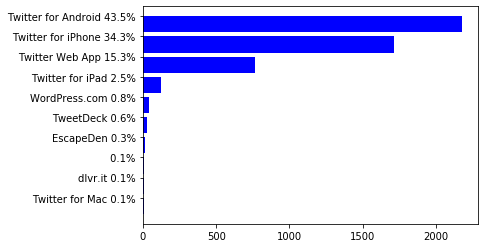

In [8]:
def get_source_name(x):
    value = re.findall(pattern="<[^>]+>([^<]+)</a>", string=x)
    if len(value) > 0:
        return value[0]
    else:
        return ""
dataset.source_name = dataset.source.apply(get_source_name)

source_counts = dataset.source_name.value_counts().sort_values()[-10:]

bottom = [index for index, item in enumerate(source_counts.index)]
plt.barh(bottom, width=source_counts, color="blue", linewidth=0)

y_labels = ["%s %.1f%%" % (item, 100.0*source_counts[item]/len(dataset)) for index,item in enumerate(source_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)

source_counts

de       25
ca       32
ar       36
tr       38
pt      118
ja      122
fr      126
und     214
es      395
en     3727
Name: lang, dtype: int64

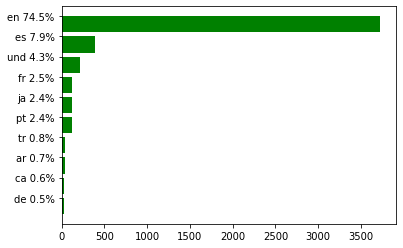

In [9]:

lang_counts = dataset.lang.value_counts().sort_values()[-10:]
bottom = [index for index, item in enumerate(lang_counts.index)]
plt.barh(bottom, width=lang_counts, color="green", linewidth=0)
y_labels = ["%s %.1f%%" % (item, 100.0*lang_counts[item]/len(dataset)) for index,item in enumerate(lang_counts.index)]
plt.yticks(np.array(bottom)+0.4, y_labels)
lang_counts

In [10]:
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from  textblob import TextBlob

In [11]:
dataset1 = [{"id": item["id"],
            "text": item["text"],
            "lang":item["lang"],
            
           } for item in col.find()]

dataset1 = pd.DataFrame(dataset1)

is_dataset1=dataset1.lang=="en"
dataset1=dataset1[is_dataset1]
dataset1

,id,text,lang
1,1318647733310410758,"RT @Fayokunmii: 20:10:2020, Nigeria bleed!\nUn...",en
3,1318647732408647691,"FOOD DISTRIBUTION ALERT: \n\nWEDNESDAY, OCTOBE...",en
4,1318647733394264064,RT @MrOdanz: Lekki blood gate. 20-10-2020. Nev...,en
6,1318647733322944520,RT @TrumpWarRoom: Photo shows Joe Biden meetin...,en
7,1318647733427818501,"RT @cmclymer: @paulsperry_ Wow, where do we ev...",en
...,...,...,...
4995,1318648149360185344,RT @HedgeMom: I cannot stress enough American ...,en
4996,1318648149540507649,JUST IN: Fairhope Council Supports Local Amend...,en
4997,1318648149746065416,RT @DreIsolid: Let it b on record that on the ...,en
4998,1318648149762805761,RT @bensonedo_: The lekki tollgate massacre. 2...,en


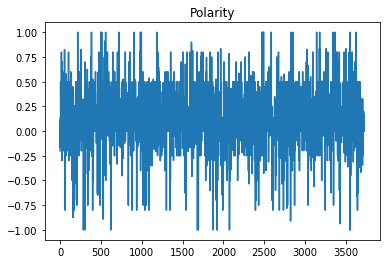

In [12]:
tweettext=dataset1['text']
wordlist=pd.DataFrame();

polarity=[]
subj=[]

for t in tweettext:
    tx= TextBlob(t)
    polarity.append(tx.sentiment.polarity)
    subj.append(tx.sentiment.subjectivity)

poltweet= pd.DataFrame({'polarity':polarity,'subjectivity':subj})
poltweet.polarity.plot(title='Polarity')
plt.show()

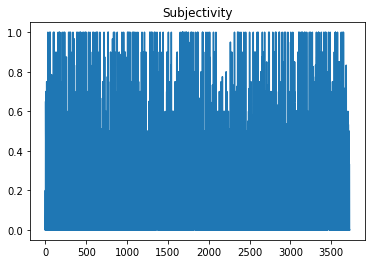

In [13]:

poltweet.subjectivity.plot(title='Subjectivity')
plt.show()

In [14]:

import statistics
statistics.mean(poltweet.polarity)

0.06896764358114152

In [15]:
import statistics
statistics.mean(poltweet.subjectivity)

0.26788353478771376

In [16]:
!pip install wordcloud
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [17]:

from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
top_N = 100
#convert list of list into text
#a=''.join(str(r) for v in df_usa['title'] for r in v)

a = dataset1['text'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)
nltk.download('stopwords')
nltk.download('punkt')
#remove all the stopwords from the text
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)
word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


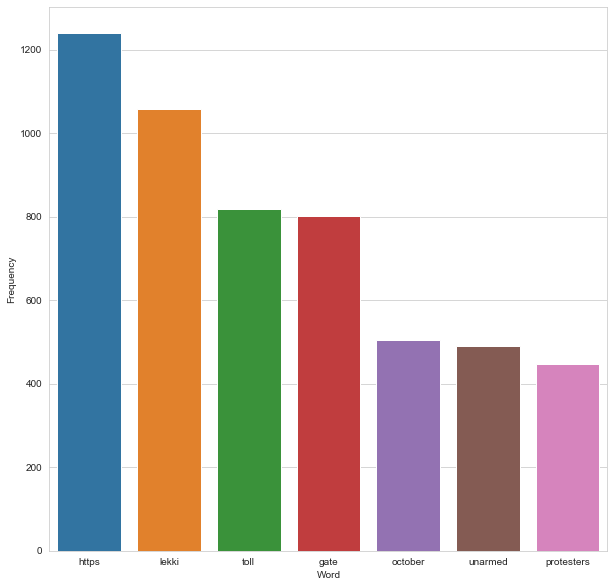

In [18]:
import seaborn as sns
# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

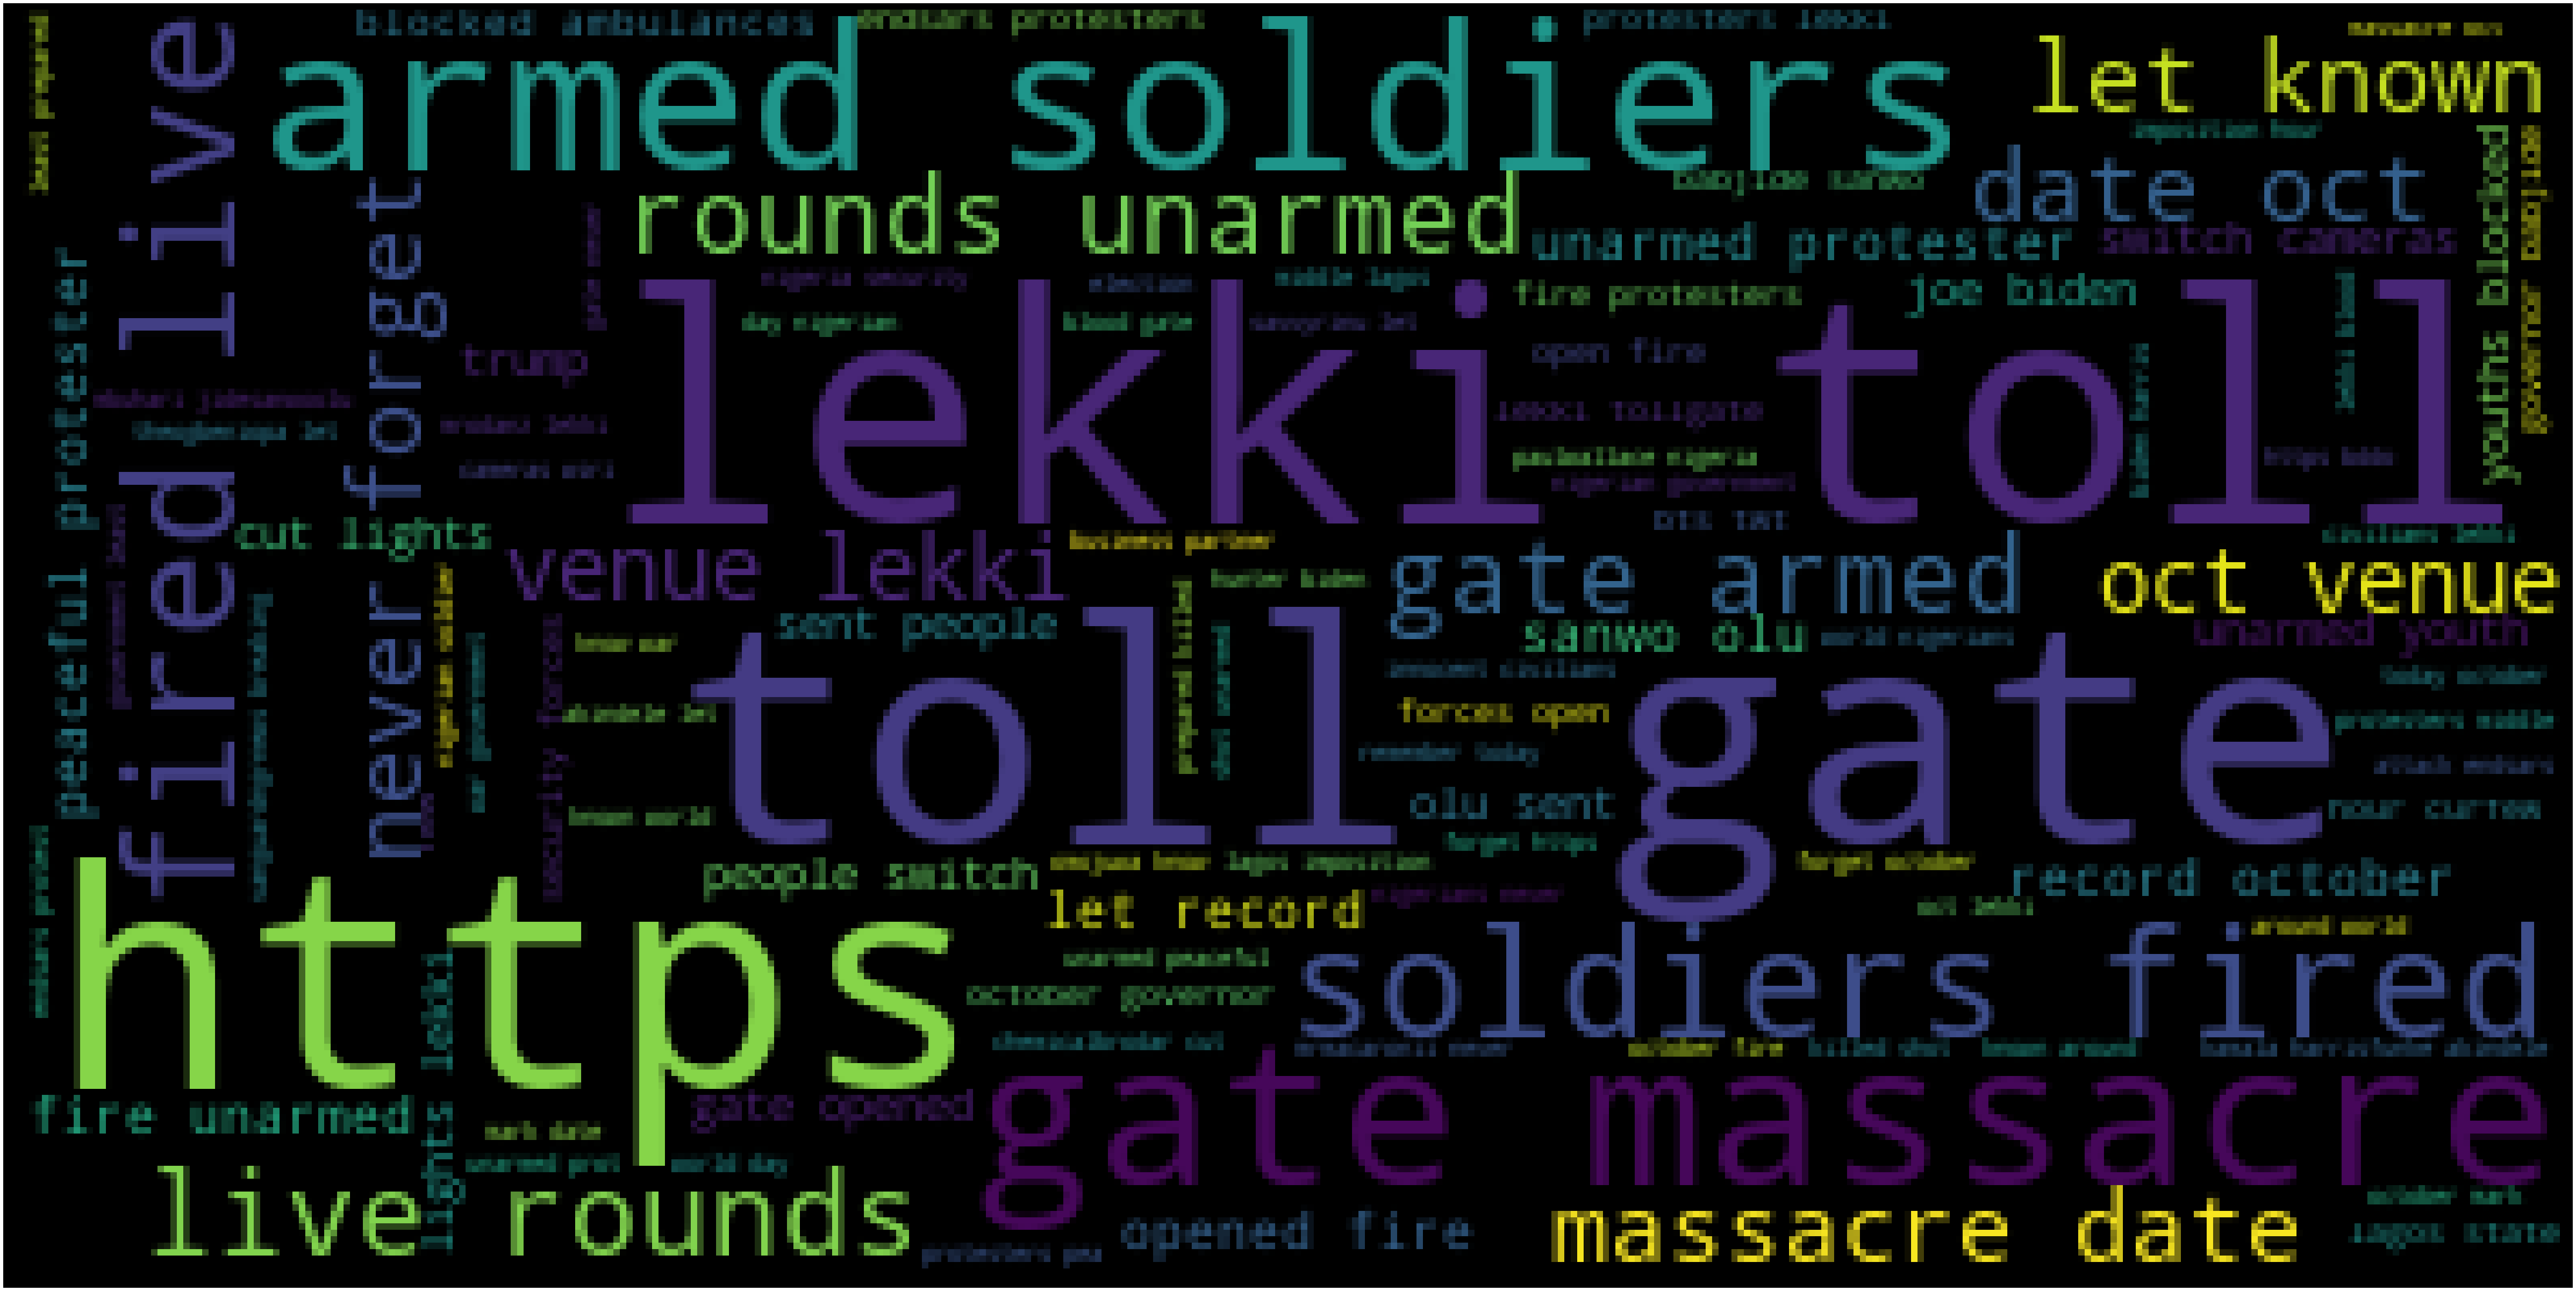

In [19]:
wc(cleaned_data_title,'black','Common Words' )

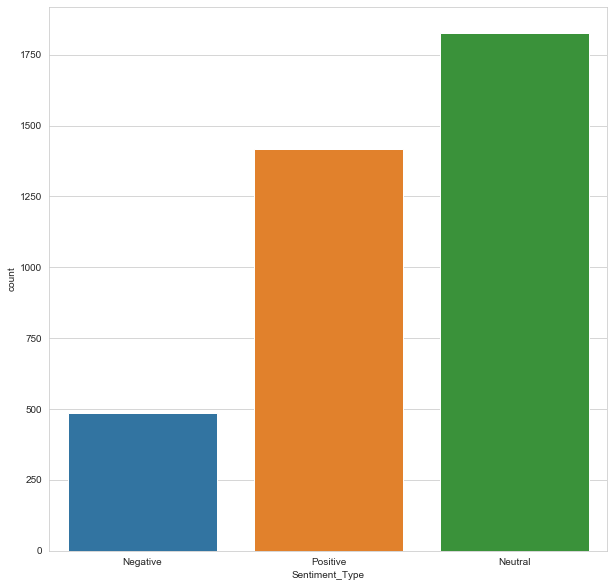

In [20]:
from textblob import TextBlob

bloblist_desc = list()

twit=dataset1['text'].astype(str)
for row in twit:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    twit_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])
    
def f(twit_polarity_desc):
    if twit_polarity_desc['sentiment'] > 0:
        val = "Positive"
    elif twit_polarity_desc['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

twit_polarity_desc['Sentiment_Type'] = twit_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=twit_polarity_desc)

In [21]:

import collections, numpy as np
a=twit_polarity_desc.Sentiment_Type
neut=np.count_nonzero(a == 'Neutral')
pos=np.count_nonzero(a == 'Positive')
neg=np.count_nonzero(a == 'Negative')
popularity='{0:.2f}'.format((((neut*0.5)+(pos)+(neg*0))/(neut+pos+neg))*100)
popularity

'62.49'